# Assignment 2

$\textbf{Author:}$ Loisa Roma Taylor   
$\textbf{Date:}$ 28 February



The goal of the assignment is for you to develop a model (descriptive or predictive) of either (a) energy generation, (b) energy demand or (c) curtailment based on the Orkney energy database. You can train/deploy the model locally on your laptop or on Azure.

### Questions:
1. How do you explore the Orkney Energy database. What insight do you get about the data? What is the relationship between your data exploration and you choice of which model you develop?

2. Describe your solution for accessing the database, designing/training the model and deploying it.

3. The Orkney Energy database evolves constantly. How often should you re-train your model? How does your solution change to support re-training? How do you decide to deploy a re-trained model?

### Packages used

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from influxdb import InfluxDBClient
from dateutil.parser import parse
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

## Loading in the data

In [2]:
client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

measurements = client.get_list_measurements()

# Print list of measurements in database
print("Measurements:\n",measurements)

# Perform a simple query
results = client.query('SELECT * FROM "Wind" WHERE time > now() - 1d ORDER BY time') # Query written in InfluxQL
points = results.get_points()
print("=====")
print("Num points received:", len(results.raw["series"][0]["values"]))

Measurements:
 [{'name': 'ANM_Operation'}, {'name': 'Demand'}, {'name': 'Generation'}, {'name': 'Generator_Site_Issues'}, {'name': 'SHEPD_Equipment'}, {'name': 'Temperature'}, {'name': 'Wind'}]
=====
Num points received: 16


## Data exploration
### Demand

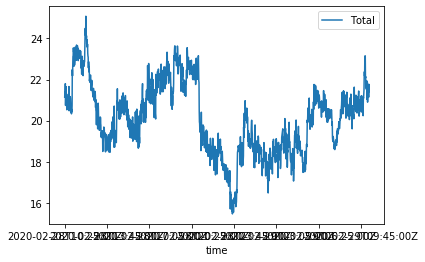

In [3]:
results = client.query('SELECT * FROM "Demand" WHERE time > now() - 1d ORDER BY time') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

In [4]:
columns

['time', 'Total']

### Generation

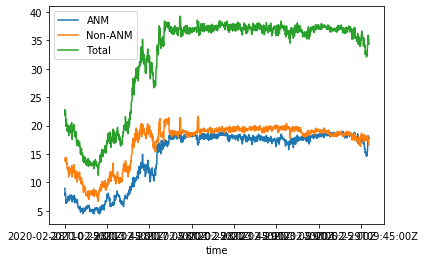

In [5]:
results = client.query('SELECT * FROM "Generation" WHERE time > now() - 1d ORDER BY time') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

In [6]:
columns

['time', 'ANM', 'Non-ANM', 'Total']

### Temperature

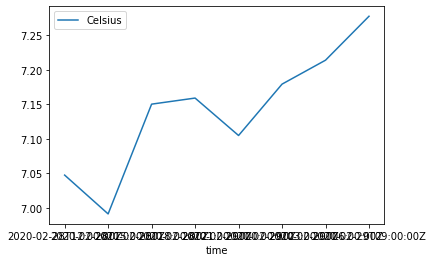

In [7]:
results = client.query('SELECT * FROM "Temperature" WHERE time > now() - 1d ORDER BY time') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

In [8]:
columns

['time', 'Celsius', 'latitude', 'longitude']

### Wind

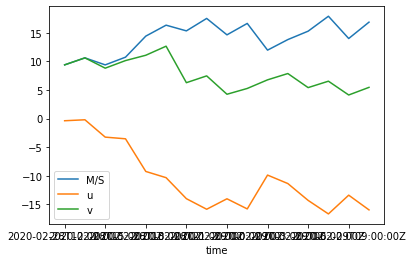

In [9]:
results = client.query('SELECT * FROM "Wind" WHERE time > now() - 1d ORDER BY time') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

In [10]:
columns

['time', 'M/S', 'height', 'latitude', 'longitude', 'u', 'v']

## Other graphs for demand

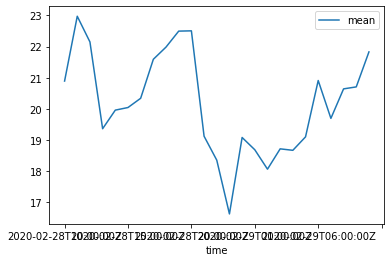

In [11]:
results = client.query('SELECT mean(Total) FROM "Demand" WHERE time > now() - 1d GROUP BY time(1h)') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

In [12]:
results = client.query('SELECT stddev(Total) FROM "Demand" WHERE time > now() - 365d GROUP BY time(1d)')
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")

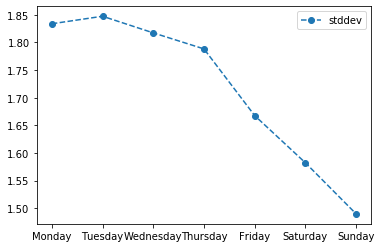

In [13]:
daynames = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

df["weekdays"] = [parse(d).isoweekday() for d in df.index] 
grouped = df.groupby("weekdays").mean()
grouped.index = daynames
grouped.plot(style="o--")

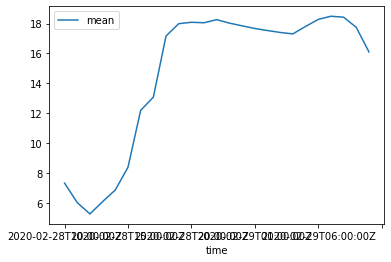

In [14]:
results = client.query('SELECT mean("ANM") FROM "Generation" WHERE time > now() - 1d GROUP BY time(1h)') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
vals = np.array(values)
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

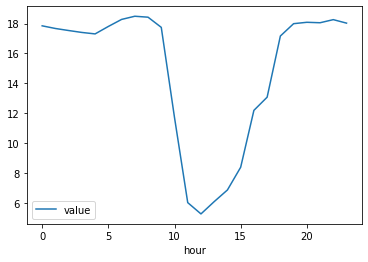

In [15]:
splitted_data = []
for time, val in values:
    splitted_data.append([int(time.split('T')[1][0:2]), val])

data = np.array(splitted_data)
df = pd.DataFrame(data, columns=['hour', 'value'])
df = df[df.value.notnull()]

grouped = df.groupby(['hour']).sum()/df.groupby(['hour']).count()
df = pd.DataFrame(grouped)
df.plot()

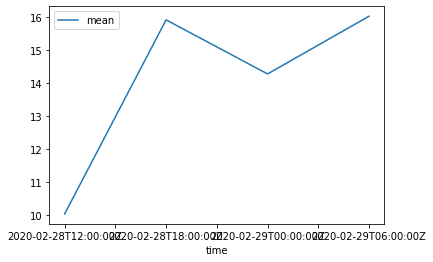

In [16]:
results = client.query('SELECT mean("M/S") FROM "Wind" WHERE time > now() - 1d GROUP BY time(6h)') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df.plot()

In [17]:
results = client.query('SELECT mean(*) FROM "ANM_Operation" WHERE time > now() - 300d GROUP BY time(1h)') # Query written in InfluxQL
values = results.raw["series"][0]["values"]
columns = results.raw["series"][0]["columns"]
df = pd.DataFrame(values, columns=columns).set_index("time")
df

,mean_Core Zone,mean_Zone 1,mean_Zone 1A,mean_Zone 2,mean_Zone 2A,mean_Zone 2B,mean_Zone 3,mean_Zone 4,mean_Zone 4A
time,,,,,,,,,
2019-05-05T10:00:00Z,1.0,1.0,1.0,0.685714,1.000000,0.500000,0.571429,1.0,1.0
2019-05-05T11:00:00Z,1.0,1.0,1.0,0.466667,1.000000,0.500000,0.458333,1.0,1.0
2019-05-05T12:00:00Z,1.0,1.0,1.0,0.575000,0.975000,0.466667,0.400000,1.0,1.0
2019-05-05T13:00:00Z,1.0,1.0,1.0,0.591667,0.991667,0.475000,0.600000,1.0,1.0
2019-05-05T14:00:00Z,1.0,1.0,1.0,0.500000,0.908333,0.425000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-02-29T06:00:00Z,1.0,0.0,0.0,0.500000,1.000000,0.500000,0.000000,0.0,0.0
2020-02-29T07:00:00Z,1.0,0.0,0.0,0.500000,1.000000,0.500000,0.000000,0.0,0.0
2020-02-29T08:00:00Z,1.0,0.0,0.0,0.650000,1.000000,0.500000,0.000000,0.0,0.0


## Questions 1
#### How do you explore the Orkney Energy database?
I start by exploring the data through loading in the 5 relevant measurements and plot them, looking at each of their coloumns and the clear trends in the data. In general, getting to know the given domain and asking Niels questions about the different variables, for example:

* What is ANM generated?
$%ANM is the wind that is generated by machines that can be turned on and off, where non-ANM is the electricity generated by the machines which always run, they cannot be turned off. This is due to ANM being applied after 2009, so the machines from before 2009 is non-ANM and the machines afterwards are by law ANM.$

* What is the 'u' and 'v' variable in wind?
$%These are wind terms, so it is calcualting the speed of the wind based on the latitude and longtitude at a given height u is the x-axis on a map and v is the y-axis on a map, then we can calculate it for N, S, E, W$

* Why are there 'latitude', 'longitude' for wind and temperature ?
$%It is to place where the measurements where taken, at this moment they are all from the same place, however, later it may be expanded to measure other geographical areas.$


#### What insight do you get about the data? 
The insights I get about the data is how it behaves, what are the variables, how often data is received and which trends occur for each of the 5 measurements. The ANM generated power is in general following the trends of the demand curve. I also looked into the demand during the day, seeing how the demand for electricity is going up significantly after 15:00 when people start getting home from work and need cook food, then after 21:00 it drastically drops again. 

#### What is the relationship between your data exploration and you choice of which model you develop?
Based on my new knowledge of the domain I decide which model I would like to develop. I choose to develop a predictive model that predicts ANM curtailment based on generation, time, demand and weather. The reason for this choice is that the domain insight indicates that there may be a good correlation between these measurements, and therefore the model would predict well. It is clear from the graphs that there is a relation between demand and generation. 

At first, I created a descriptive model of the relation between ANM and the other measures, it tries to predict whether or not the ANM value is going down, assuming that a decreasing ANM value equals curtailment(which it does not). This model uses the wind values together with demand and non-ANM.

The next model uses ANM_operation which is the real curtailment values. The model still uses demand and weather measures and tries to predict 0/1, where 1 means that one of the zones are curtailed. This is a model that predicts curtailment.

## Loading in the relevant data and turned it into a combined pandas dataframe with a sample for each hour

In [18]:
def loading(descriptive=False):
    df = pd.DataFrame()

    results = client.query('SELECT mean(Total) FROM "Demand" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
    values = results.raw["series"][0]["values"]
    df = pd.concat([df, pd.DataFrame(values,columns=['time', 'demand'])], axis=1)
    results = client.query('SELECT mean("M/S") FROM "Wind" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
    values = results.raw["series"][0]["values"]
    df = df.merge(pd.DataFrame(values, columns=['time', 'wind']), on='time')
    results = client.query('SELECT mean("u") FROM "Wind" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
    values = results.raw["series"][0]["values"]
    df = df.merge(pd.DataFrame(values, columns=['time', 'u wind']), on='time')
    results = client.query('SELECT mean("v") FROM "Wind" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
    values = results.raw["series"][0]["values"]
    df = df.merge(pd.DataFrame(values, columns=['time', 'v wind']), on='time')
    
    if descriptive == True:
        results = client.query('SELECT mean("Non-ANM") FROM "Generation" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
        values = results.raw["series"][0]["values"]
        df = df.merge(pd.DataFrame(values, columns=['time', 'Non-ANM']), on='time')
        
        results = client.query('SELECT mean("ANM") FROM "Generation" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
        values = results.raw["series"][0]["values"]
        df = df.merge(pd.DataFrame(values, columns=['time', 'ANM']), on='time')
        
        df = df.fillna(0)

        return df
    
    results = client.query('SELECT mean(*) FROM "ANM_Operation" WHERE time > now() - 365d GROUP BY time(1h)') # Query written in InfluxQL
    values = results.raw["series"][0]["values"]
    
    df_val = pd.DataFrame()
    df_val['time'] = np.array(values)[:,0]
    df_val['curtailment'] = np.array(values)[:,0]
    
    for idx, i in enumerate(np.array(values)[:,1:].astype(float)):
        if sum(i) > 1:
            df_val['curtailment'].iloc[idx] = 1
        else:
            df_val['curtailment'].iloc[idx] = 0
    df = df.merge(pd.DataFrame(df_val, columns=['time', 'curtailment']), on='time')
    df = df.fillna(0)

    return df

# Turning the ANM values into true/false (1/0) 

In [19]:
def classification_values(df):
    prev = 0
    array = df.values

    for idx, i in enumerate(array):
        if prev < i[-1]:
            prev = i[-1]
            array[idx,-1]= 0

        else:
            prev = i[-1]
            array[idx,-1] = 1
    df = pd.DataFrame(array)
    array = np.array(df)
    
    return array

### Changing the wind 0 values into the mean of the values around it

In [20]:
def shifted_values(array):
    means = np.mean(array[:,1:].astype(float),axis=0)
    
    for num in range(0,len(array[0])-1):
        for idx,i in enumerate(array):
            startidx = 0
            if i[num] == 0.0:
                for x in range(idx, len(array)):
                    if array[x][num] != 0.0:
                        mean = np.mean([array[startidx,num], array[x,num]])  

                        if mean == 0:
                            mean = means[num]
                array[idx,num] = mean
            else:
                startidx = idx
     
    for i in range(len(array)-1):
        for j in range(len(array[i])-1):
            if array[i,j]==0:
                array[i,j] = np.mean([array[i-1,j],array[i+1,j]])

    return array

### Dividing the data into x/y tables and train/test tables.

In [21]:
def split(array):
    per = int(len(array)*0.8)
    
    np.random.seed(1)
    np.random.shuffle(array)

    x_train = array[:,1:-1][:per]
    y_train = list(array[:,-1])[:per]
    
    x_test = array[:,1:-1][per:]
    y_test = list(array[:,-1])[per:]
    
    return x_train, y_train, x_test, y_test

## Model 1 - descriptive

In [22]:
df = loading(descriptive=True)
cleaned = shifted_values(classification_values(df))
x_train, y_train, x_test, y_test = split(cleaned)

In [23]:
x_train.shape, len(y_train), x_test.shape, len(y_test)

((7008, 5), 7008, (1753, 5), 1753)

In [24]:
def train(x_train, y_train, x_test, y_test):
    model = SVC(kernel="linear").fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv = KFold(n_splits=5, random_state=1), scoring = "accuracy")

    acc_test = model.score(x_test, y_test)

    print('Accuracy development data: ', round(np.mean(score),3), '  min:', round(np.min(score),3), 'max:', round(np.max(score),3))
    print('Accuracy test data:        ', round(acc_test,3))
    
    return model

In [25]:
model = train(x_train, y_train, x_test, y_test)
pred = model.predict(x_test)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy development data:  0.562   min: 0.556 max: 0.571
Accuracy test data:         0.552


## Model 2 - predictive

In [26]:
df = loading()
cleaned = shifted_values(np.array(df))
x_train, y_train, x_test, y_test = split(cleaned)

In [27]:
x_train.shape, len(y_train), x_test.shape, len(y_test)

((7008, 4), 7008, (1753, 4), 1753)

### Trying out  different sklearn classification models using 5-fold cross-validation

In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

means = []

models = []
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("LR", LogisticRegression()))
models.append(("NB", GaussianNB()))
models.append(("RF", RandomForestClassifier()))
models.append(("SVC L", SVC(kernel="linear", C=0.025)))
models.append(("SVC G", SVC(kernel="rbf")))
models.append(("Dtree", DecisionTreeClassifier()))
models.append(("KNN", KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=5, random_state=1)
    cv_result = cross_val_score(model, x_train, y_train, cv = kfold, scoring = "accuracy")
    print('{:5} round accuracies: {}'.format(name, cv_result))
    means.append(np.mean(cv_result))
    
print('best performing model', models[np.argmax(means)])

LDA   round accuracies: [0.67261056 0.64978602 0.67332382 0.66523911 0.67523198]
LR    round accuracies: [0.67332382 0.65121255 0.67261056 0.66595289 0.67665953]
NB    round accuracies: [0.67332382 0.65263909 0.66405136 0.66523911 0.65453248]
RF    round accuracies: [0.64835949 0.64336662 0.65121255 0.65024982 0.65810136]
SVC L round accuracies: [0.66761769 0.64550642 0.67189729 0.66095646 0.67523198]
SVC G round accuracies: [0.68188302 0.66619116 0.68259629 0.6716631  0.68165596]
Dtree round accuracies: [0.63623395 0.62767475 0.63480742 0.63240542 0.63740186]
KNN   round accuracies: [0.66476462 0.65263909 0.65834522 0.66167024 0.66381156]
best performing model ('SVC G', SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))


## Training the best performing model

In [29]:
def train(x_train, y_train, x_test, y_test):
    model = SVC(kernel="rbf").fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv = KFold(n_splits=5, random_state=1), scoring = "accuracy")

    acc_test = model.score(x_test, y_test)

    print('Accuracy development data: ', round(np.mean(score),3), '  min:', round(np.min(score),3), 'max:', round(np.max(score),3))
    print('Accuracy test data:        ', round(acc_test,3))
    
    return model

### Predict latest values

In [30]:
model = train(x_train, y_train, x_test, y_test)
pred = model.predict(x_test)

Accuracy development data:  0.677   min: 0.666 max: 0.683
Accuracy test data:         0.696


## Question 2
#### Describe your solution for accessing the database
My solution for accessing the database is to use the two types of queries written in InfluxQL where I either show all values of one table for a timeframe or group by a timeframe and show the mean value. 

- client.query('SELECT * FROM "Demand" WHERE time > now() - 1d ORDER BY time')
- client.query('SELECT mean(Total) FROM "Demand" WHERE time < now() - 1d GROUP BY time(1h)')


#### Describe your solution for designing/training the model
First I need to choose my features based on the input my model needs. All of my data is grouped by time(1H), this is due to each measurement receiving new data at different times. The wind measurement is only receiving new data every 6h and the other data is grouped by 1h, therefore, I started by setting all the 'NaN' values in the wind data to the mean of the non-Nan value before and after the NaN values. Curtailment happend quite frequently and it would only give four predictions throughout a day if the values was predicted every 6h. 

#### Describe your solution for deploying the model
##### Model 1:
I combine the demand, non-ANM generation and wind measurements into a x_table, these are the values I train on. Then I create the y_table, which is the values I want to predict. The purpose of the model is to predict a decrease in ANM generated power, this is a classification problem, therefore, I turn the ANM generator values into true false (0/1) values, indicating whether or not it predicts a decrease. If the previous value is larger than the current value there is decrease and the value is true/1. The acurracy was not very high (around 0.54) even though it is a binary classification problem, therefore, I reconsidered the feature selection. After tuning the model the accuracy is stil below 0.60, therefore, it can be concluded that demand, wind and non-ANM cannot predict whether or not the ANM value decrease, and they cannot descripe if there is curtailment. 


##### Model 2:
For the predictive model I combined demand and wind measurements as the training data and the y-value is then the mean of the curtailment in all zones, if the combined mean for each hour is above 1 it is set as 1 and therefore indicating curtailment. The purpose of the model is to predict an overall curtailment in all zones using measures that can be predicted, such as weather. Next, after the features was selected then I designed the model, testing out different sklearn classification models. The split between train and test data is 0.8/0.2. The predictive model can predict with an accuracy of 70%.


### Conclusion of model results
The conclusion of model 1 is that it is not good at predicting if the ANM value is going down, showing that their is not a correlation between wind, demand, non-ANM and ANM. I believed that if the non-ANM value was steady, but the ANM value went down, then there is curtailment. I also believed that if the non-ANM was steady, but the demand is decreasing then there is also curtailment, however, this was also a pattern that the models did not find. 

The conclusion for model 2 is that it has a significantly higher accuracy, around 70%. It is able to predict curtailment in general using information such as previous demand and wind measures. This model is then described further in the questions about re-training. 

Both models use data from 365 days, the models have been tested out on all of the data, however, this resulted in a decrease of around 7% in accuracy, this can be because the old data has more missing values and they are not ass representative as the data from within a year. 

## Retrain and predicting

In [31]:
! python3 retraining.py
! python3 predicting.py
! head -10 predicted_curtailment.csv

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
Accuracy development data:  0.678   min: 0.494 max: 0.852
Accuracy test data:         0.623
0
0
0
0
0
0
0
0
0
0


## Question 3
The Orkney Energy database evolves constantly. 

It is only the predictive model 2 which is re-trained

#### How often should you re-train your model? 
I only use the data points for each hour, therefore each hour the model could be retrained in order to take the new data into consideration. However, the wind measurements are recieved every six hours, therefore, it can be argued that the model should be retrained after six hours. 

Curtailment is something that happen multiple times throughout the day and therefore the model should predict every hour before the curtailment happens. 


#### How does your solution change to support re-training? 
In order to support retraining another format is needed, therefore, I created two python files, 'retraining.py' and 'predicting.py', the retrained model is saved as a pickle, and then loaded in when predicting values. 

Every time the script runs it uses the newest data from the last year. The model cannot be re-trained without the previously used data, every time the model is re-trained the whole model is trained again. 

#### How do you decide to deploy a re-trained model?
A possible solution to re-training the model is periodically retraining the model. The choice is then when to retrain the model. If all resourceses are avaliable then a job shceduler can retrain the model every 6 hours and predict values every hour using the two python files. The prediction file by default predicts the last hour's curtailment. 

A more complex method is automated model drift detection. It tracks diagnostics and triggering model re-training when the diagnostics on live data diverge from the training data diagnostics. There can be a threshold of of a certain accuracy, and if the new prediction is below the threshold the model is re-trained this is called automated model drift detection. However, this would need to be implemented together with a job scheduler, in order to keep predicting values every hour automatically and check for drifting accuracy. Also, the python files would need to change in order to collect the accuracies and being able to trigger re-training at a threshold. 
https://mlinproduction.com/model-retraining/ 

Another option is to use Microsoft Azure to get the data from the database, create a model, retrain it and predict using new data. It creates a whole pipeline and an simple frame to deploy everything, however, this is an expensive solution compared to a smaller job scheduler. 